# <center>R5.A.11 - Méthodes d'optimisation <br> TP2b -- Flot version 2 & Régression linéaire</center>


-------------

_Tom Ferragut & Thibault Godin_

_IUT de Vannes, BUT Informatique_


-------------

Ce TP est composé de deux parties principalements indépendantes. Le premier objectif de ce TP est de proposer une autre méthode de résolution du problème du flot maximal, vu en R5.A.12 (avec résolution par Edmond-Karp / Ford-Fulferson) en transformant ce problème en un problème d'optimisation linéaire. Puis nous nous intéresserons à la méthode de régression linéaire du point de vue de l'optimisation linéaire. 

In [8]:
import numpy as np

import random

import networkx as nx

import math
# Affichage graphique

#%matplotlib notebook 
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisalgèbreation

%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.cm import ScalarMappable

import time

import networkx as nx


from ipywidgets import interact, fixed
import ipywidgets as widgets

plt.rcParams["figure.figsize"] = [12, 12]

rng = np.random.default_rng(12345)

np.set_printoptions(precision=3)
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

# 1 - Flots

## 1.1 - Rappels sur les flots
### (TP de modélisation de la semaine dernière)


On considère $G = (S, A)$ un graphe orienté avec une fonction de _capacité_ $c : S\times S \to \mathbb{N}$ telle que :

- $\forall (u, v) \in A$, $c(u, v) > 0$

- $\forall (u, v) \notin A$, $c(u, v) = 0$


Dans ce graphe on distingue 2 sommets particuliers
- $s$ : la source ($d^- = 0$, pas d'arêtes entrantes)
- $t$ : le puits ($d^+ = 0$, pas d'arêtes sortantes)

Sur un tel graphe, un _flot_ est une fonction $f : S^2 \to \mathbb{R}$ telle que :

- **Contraintes de capacité** : $f(u,v) \le c(u,v)$ (la quantité de flot sur un arc ne dépasse pas la capacité de cet arc)

- **Anti-symétrie** $f(u,v) = - f(v,u)$

- **Conservation du flot** $\sum_{w \in S} f(u,w) = 0$ , sauf si $u=s$ ou $u=t$ (sur chaque sommet sauf $s$ et $t$, la somme des flots entrants est égale à la somme des flots sortants)

- La _valeur_ totale du flot est $\sum_{(s,u) \in A} f(s, u) = \sum_{(v,t) \in A} f(v, t)$.

Voici un exemple de graphe orienté, où la capacité de chaque arrête est indiquée et où la source et le puits sont les sommets verts. L'illustration a été réalisée en utilisant la bibliothèque `networkx`.

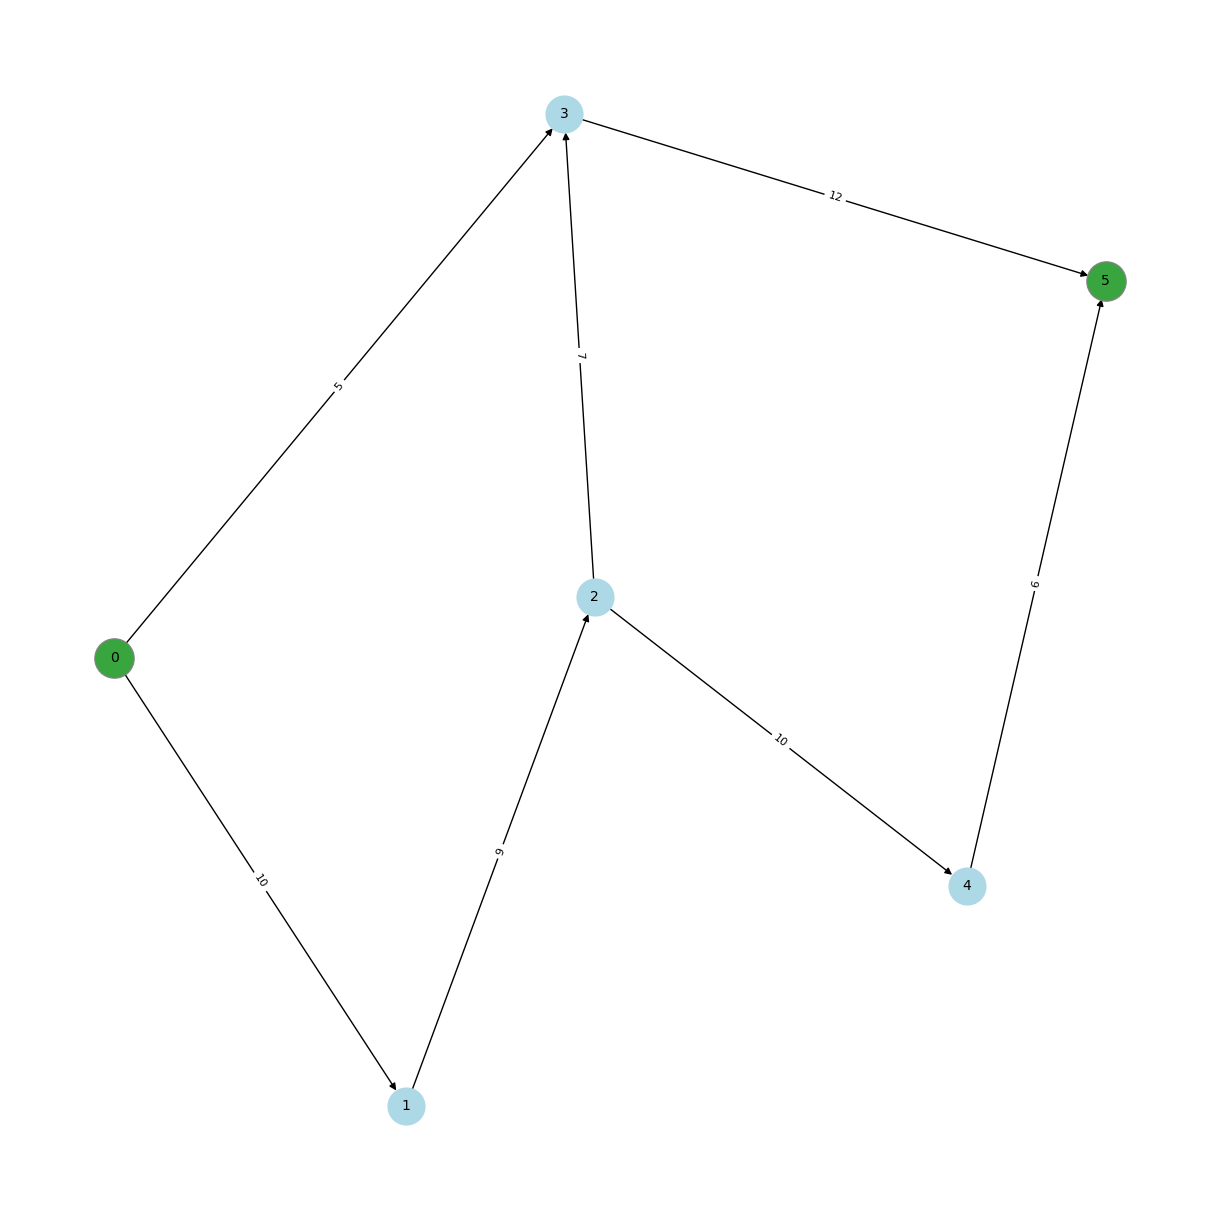

In [15]:
# Capacity of G's edges
capacity_matrix = np.array([
    [0, 10, 0, 5, 0, 0],
    [0, 0, 9, 0, 0, 0],
    [0, 0, 0, 7, 10, 0],
    [0, 0, 0, 0, 0, 12],
    [0, 0, 0, 0, 0, 6],
    [0, 0, 0, 0, 0, 0]
])

source = 0
puits = 5

# Create a directed graph from the capacity matrix
G = nx.DiGraph()
for i in range(len(capacity_matrix)):
    for j in range(len(capacity_matrix[0])):
        if capacity_matrix[i][j] > 0:
            G.add_edge(i, j, capacity=capacity_matrix[i][j])
            
for u, v, data in G.edges(data=True):
    capacity = data['capacity']
    
# Draw the graph with edge labels
pos = nx.spring_layout(G)
labels = {edge: f"{G.edges[edge]['capacity']}" for edge in G.edges}
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_color='black')
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=[source, puits], node_color="tab:green", **options)
#nx.draw_networkx_edges(G, pos, edge_color='edge_colors', width=3, edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)

plt.show()

## 1.2 - Problème du flot et optimisation linéaire
### Formulation équivalente

La formulation

>- **Contraintes de capacité** : $f(u,v) \le c(u,v)$ (la quantité de flot sur un arc ne dépasse pas la capacité maximale de cet arc)
>
>- **Anti-symétrie** $f(u,v) = - f(v,u)$
>
>- **Conservation du flot** $\sum_{w \in S} f(u,w) = 0$ , sauf si $u=s$ ou $u=t$ (sur chaque sommet sauf s et t, >la somme des flots entrants est égale à la somme des flots sortants)
>
>- La _valeur_ totale du flot est $\sum_{(s,u) \in A} f(s, u) = \sum_{(v,t) \in A} f(v, t)$

ressemble fortement à un problème d'optimisation linéaire. On peut en effet le reformuler comme :


**Maximiser**  $\quad\sum_{(s,u) \in A} f(s, u) \quad\text{sous les contraintes}\quad \forall (u,v) \in A\quad \begin{cases}
&f(u,v) \le c(u,v)\\
&f(u,v) \ge 0 \\
&\sum\limits_{x \text{ voisin sortant de } u } f(u,x) \ -\  \sum\limits_{y \text{ voisin entrant de } u} f(y, u) = 0 \\
&\sum\limits_{w \in S} f(u,w) = 0 
\end{cases}$




L'inconnue de ce système est le vecteur $f$ et les variables sont les valeurs du flot sur chaque arête. On va construire :

- une matrice $A_{cons}$ qui garantira la conservation du flot
- un vecteur $b_{cons}$, égal à $0$ sur toutes ses coordonnées
- une matrice $A_{capa}$, égale à la matrice identité
- un vecteur $b_{capa}$ qui contiendra les capacités de chaque arête
- un vecteur de coût $c$ qui vaut $1$ sur les arêtes sortant de $s$



Plus précisément la matrice $A_{cons}$ sera une matrice a (nombre de sommets -2 [la source et le puits]) lignes et (nombre d'arêtes) colonnes (il s'agit en fait de la matrice d'incidence où l'on a retiré les lignes de la source et du puits). On en déduit la forme matricielle équivalente du problème d'optimisation :

$
\textbf{Maximiser } \quad c^T . f  \quad\text{sous les contraintes}\quad\begin{cases}
A_{cons} . f &= b_{cons} \\ 
A_{capa} . f &\leq b_{capa}
\end{cases}$

>**__Question 1:__**<br>
Écrire les matrices et vecteurs $c^T$, $A_{cons}$, $A_{capa}$, $b_{cons}$ et $b_{capa}$ correspondants au problème d'optimisation linéaire associé à un graphe de capacité $G$ (donné comme une matrice de capacité).<br>





In [10]:
#https://cs.au.dk/~gerth/ipsa18/slides/linear_programming.pdf

def toIncidence(M):
    n = M.shape[0]
    m = sum(sum(M.astype(bool)))
    I = np.zeros((n,m),int)
    capa = np.zeros(m) 
    cpt=0
    for i in range(n):
        for j in range(n):
            if M[i,j]!=0 : 
                I[i,cpt] = -1
                I[j,cpt] = 1
                capa[cpt] = M[i,j]
                cpt = cpt + 1
    print(cpt)           
    return I,capa
print(toIncidence(capacity_matrix))


def linearFlot(M):
    
    """
    Todo
    """
    return Acons, bcons, Acapa, bcapa, c

print(linearFlot(capacity_matrix))

7
(array([[-1, -1,  0,  0,  0,  0,  0],
       [ 1,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  1, -1, -1,  0,  0],
       [ 0,  1,  0,  1,  0, -1,  0],
       [ 0,  0,  0,  0,  1,  0, -1],
       [ 0,  0,  0,  0,  0,  1,  1]]), array([10.,  5.,  9.,  7., 10., 12.,  6.]))
7
(array([[ 1,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  1, -1, -1,  0,  0],
       [ 0,  1,  0,  1,  0, -1,  0],
       [ 0,  0,  0,  0,  1,  0, -1]]), array([0., 0., 0., 0.]), array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]]), array([10.,  5.,  9.,  7., 10., 12.,  6.]), array([1, 1, 0, 0, 0, 0, 0]))


### Résolution avec Scipy

La bibliothèque standard pour le calcul scientifique en python est scipy, qui possède une [fonction](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html) assez souple et puissante de résolution des problèmes d'optimisation linéaire.





>**Question 2 :**<br> En utilisant la fonction `linprog` de Scipy, retrouvez les résultats d'optimisation de flots du TP de modélisation. Les illustrer et les comparer au résultat trouvés en modélisation. 



In [11]:
from scipy.optimize import linprog

In [12]:
Acons, bcons, Acapa, bcapa, c  = linearFlot(capacity_matrix)

"""
TODO
"""

7
7
(4, 7)
(4,)
(7, 7)
(7,)
(7,)


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -14.0
              x: [ 9.000e+00  5.000e+00  9.000e+00  3.000e+00  6.000e+00
                   8.000e+00  6.000e+00]
            nit: 0
          lower:  residual: [ 9.000e+00  5.000e+00  9.000e+00  3.000e+00
                              6.000e+00  8.000e+00  6.000e+00]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf        inf        inf
                                    inf        inf        inf]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                              0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
                 marginals: [-1.000e+00 -0.000e+00 -0.000e+00 -0.000e+00]
        ineqlin:  residual: [ 

# 2 - Régression linéaire





Le but de cette partie est d'effectuer une **régression linéaire**, c'est-à-dire d'approcher nos données à l'aide d'une fonction affine. Elle s'inspire entre autre de [cette vidéo](https://www.youtube.com/watch?v=HgY4mpKsFFo). On reprend l'exemple de l'an dernier,  un tableau de taille et poids pour 15 personnes.


**Données :** 

| Id        | Height (cm)           | Weight (kg)  |
| ------------- |:-------------:| -----:|
| 1     | 147 |  49 |
| 2    | 150      |   50 |
|3 | 153      |     51 |
| 4     | 155 |  52 |
| 5    | 158      |   54 |
|6 | 160      |     56 |
| 7     | 163 |  58 |
| 8    | 165      |   59 |
|9 | 168      |     60 |
| 10     | 170 |  62 |
| 11    | 173      |   63 |
|12 | 175      |     64 |
| 13     | 178 |  66 |
| 14    | 180      |   67 |
|15 | 183      |     68 |
|16 | 168      |     58 |


__On voudrait approcher les données au mieux à l'aide d'une droite $y = a . x + b$.__


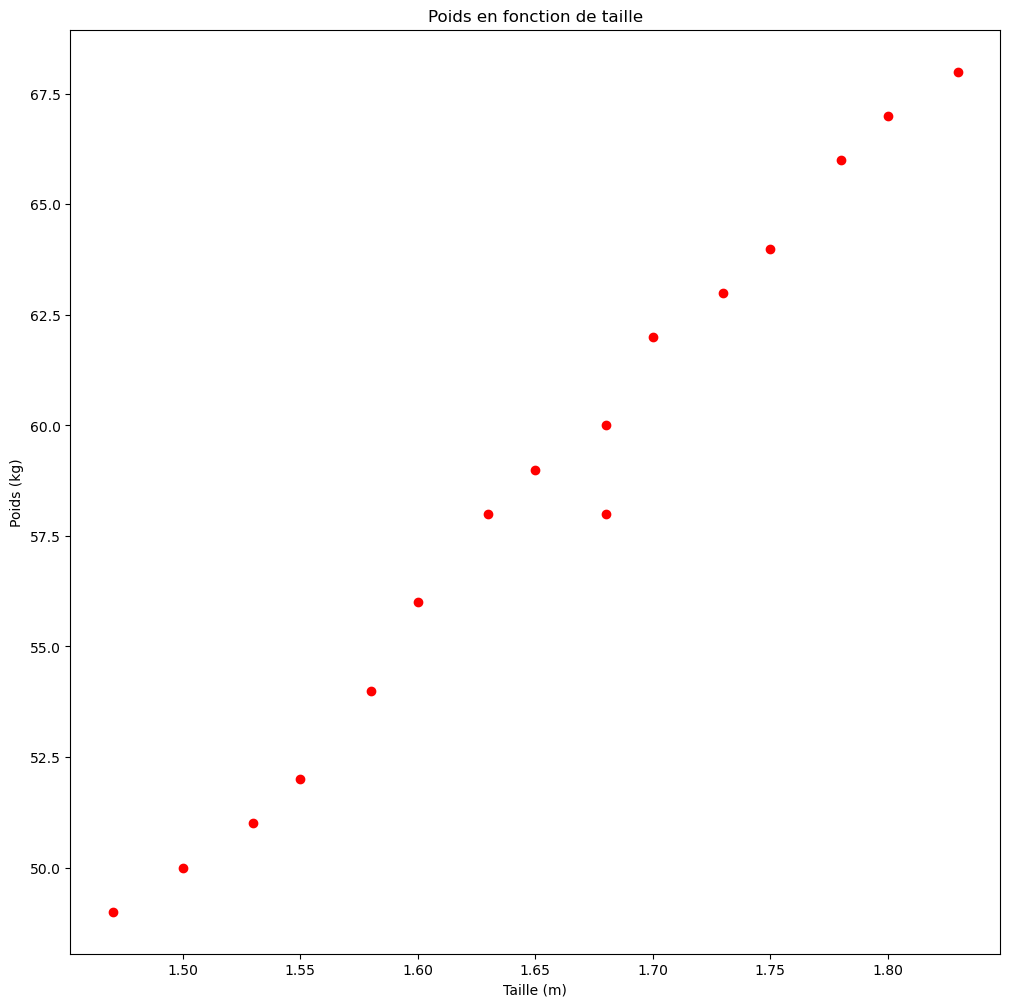

In [13]:
plt.close()

# data
#taille en mètres
x = np.array([1.47, 1.50, 1.53, 1.55, 1.58, 1.60, 1.63, 1.65, 1.68, 1.70, 1.73, 1.75, 1.78, 1.80, 1.83,1.68]) #Taille
y = np.array([49.,50.,51.,52.,54.,56.,58.,59.,60.,62.,63.,64.,66.,67.,68.,58]) #Poids

#print(X.shape)
#print(y.shape)


# plot the data
plt.scatter(x,y, color='red')
plt.title('Poids en fonction de taille')
plt.xlabel('Taille (m)')
plt.ylabel('Poids (kg)')

plt.show()



On implémente un fonction `plotDroite`, permettant à la fois d'afficher les données et d'afficher une droite de paramètres `a` et `b`. Grâce aux curseurs, on peut se faire une idée des valeurs optimales de `a` et de `b` pour la droite de régression linéaire. Nous allons dans la suite de ce TP la déterminer par différentes méthodes.

In [14]:
def plotDroite(dataX,dataY,a,b):
    
    # Representation des donnees x en fct de y
    plt.scatter(dataX,dataY, color='red')
    plt.title('Poids en fonction de taille')
    plt.xlabel('Taille (en m)')
    plt.ylabel('Poids')
    
    #Representation de la droite y=ax+b
    xinf=np.linspace(min(x)-10,max(x)+10,500)
    yinf=[a*i+b for i in xinf]
    
    plt.plot(xinf,yinf, color='blue')
    plt.ylim(min(y)-5,max(y)+5)
    plt.xlim(min(x)-0.1,max(x)+0.1)
    
    plt.tight_layout()

    plt.show()

    #Choix de la plage de valeur des curseurs
interact(plotDroite, dataX=fixed(x),dataY=fixed(y),a=(30, 60, 0.5), b=(-50, 30, .1))

interactive(children=(FloatSlider(value=45.0, description='a', max=60.0, min=30.0, step=0.5), FloatSlider(valu…

<function __main__.plotDroite(dataX, dataY, a, b)>

## 2.1 - Les moindre carrés (norme $L_2$)


La méthode des moindres carrés a été vu en R4.04 l'année dernière. Ici on cherche à minimiser la fonction $E(a,b) = \sum_i(y_ i - (ax_i + b))^2$.


Les paramètres optimaux de la droite de régression linéaire (que l'on obtient analytiquement par dérivation de $E(a,b)$ en résolvant $\nabla E(a,b) = \left[\dfrac{\partial E(a,b)}{\partial a},\dfrac{\partial E(a,b)}{\partial b}\right] = [0,0]$ ou par méthode du gradient) sont : 
- $a^* = \dfrac{cov(x,y)}{var(x)}$ 
- $b^*=\bar{y}-a^*\bar{x}\quad$   (où $\bar{x}$ et $\bar{y}$ représente la moyenne de ces vecteurs)

In [11]:
#paramètres optimaux L2 (fonctionne pour toute regression linéaire en dimension 1)

#homebrew covariance
def cov(x,y):
    return (sum([x[i]*y[i] for i in range(len(x))])/len(x)-np.mean(x)*np.mean(y))

def droite(a,b,x):
    return a*x+b

def E(a,b,x,y):
    return sum([(y[i]-(a*x[i]+b))**2 for i in range(len(x))])


#sinon, on peut utiliser la fonction de covariance de python : 
#covar = np.cov(taille,poids,bias=True)[0][1]

print('var = ',np.var(x))
print('covar = ',cov(x,y))

ast=cov(x,y)/np.var(x)
print('a* = ',ast)

bst=np.mean(y) - ast * np.mean(x)
print('b* = ',bst)


print("Erreur minimale (somme des écarts au carré):", round(E(ast, bst, x, y),2))

var =  0.0112109375
covar =  0.6285156249999915
a* =  56.062717770034084
b* =  -34.151219512193876
Erreur minimale (somme des écarts au carré): 8.16


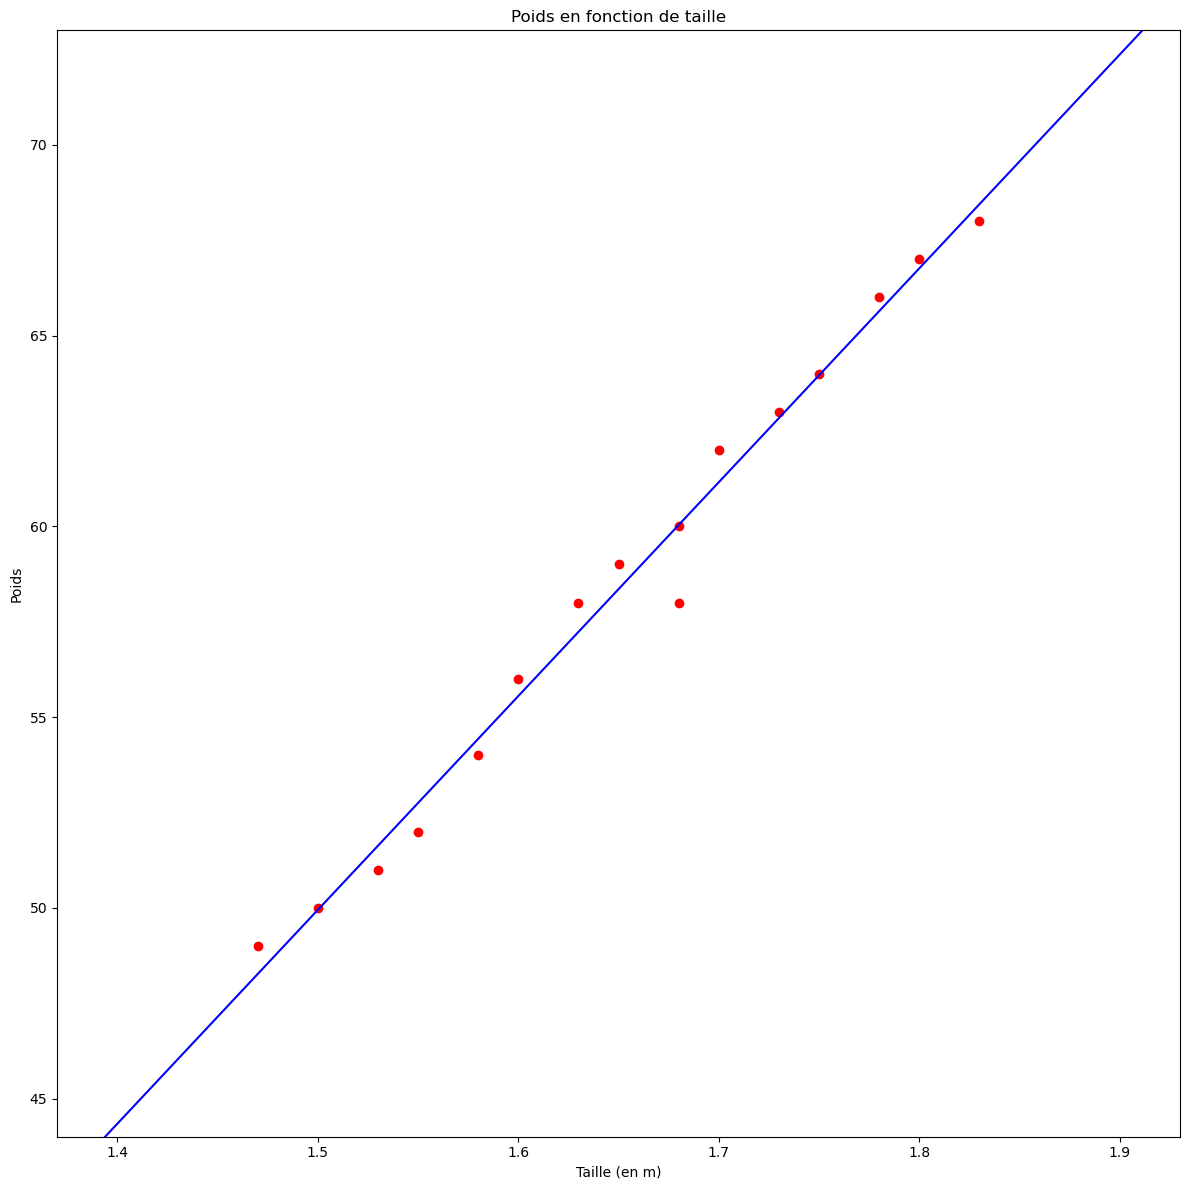

In [12]:
plotDroite(x,y,ast,bst)

## 2.2 - Moindre valeur absolue (norme $L_1$)

Cette méthode donne des résultats tout à fait pertinents et satisfaisant, cependant elle n'est pas la plus naturelle.

En effet, la fonction d'erreur qui vient en premier à l'esprit est $$E_1 (a,b) = \sum_i |y_ i - (ax_i + b)|$$.


En pratique, ce n'est pas elle que l'on choisit car la minimiser est plus difficile (théoriquement et en temps machine). Cependant on peut trouver _par programmation linéaire_ les paramètres optimaux pour ce problème, et comparer la droite ainsi obtenue à celle des moindre carrée.

Partons de 
$$E_1 (a,b) = \sum_i |y_ i - (ax_i + b)|$$

On écrit $e_i = |y_ i - (ax_i + b)|$, le problème devient alors :

$\text{ Minimiser}\quad \sum_i e_i \quad$ sous les contraintes  $\quad\begin{cases}e_i  = |y_ i - (ax_i + b)|\end{cases}$

Que l'on réécrit encore :

$\text{ Minimiser}\quad \sum_i e_i \quad$ sous les contraintes $\quad\begin{cases}e_i  &\leq y_ i - (ax_i + b)\\
e_i  &\geq - (y_ i - (ax_i + b))
\end{cases}\quad$ soit $\quad\begin{cases}e_i  &\leq y_ i - (ax_i + b)\\
-e_i  &\leq y_ i - (ax_i + b)
\end{cases}$

Nous pouvons le reformuler sous une forme plus proche d'un problème linéaire :


$\text{ Maximiser}\quad\quad -\sum_i e_i \quad$ sous les contraintes $\quad\begin{cases}
ax_i  + b   + e_i  &\leq y_ i\\
-ax_i - b - e_i  &\leq -y_ i
\end{cases}$

On considère le vecteur $(a,b,e_1, ... ,e_n)$.

>__Question 3 :__
Écrire les matrices $c_{lp}$, $A_{lp}$ et $b_{lp}$ permettant de mettre ce problème sous la forme matricielle :
>
>$\text{Maximiser}\quad c_{lp} (a,b,e_1, ... ,e_n) \quad$ sous la contrainte $\quad\begin{cases}
A_{lp} (a,b,e_1, ... ,e_n) &=b_{lp}\\
\end{cases}$ 

In [30]:
"""
TODO
"""

[1.47 1.5  1.53 1.55 1.58 1.6  1.63 1.65 1.68 1.7  1.73 1.75 1.78 1.8  1.83 1.68]
(32, 16) (32, 1) (32, 1)
(32, 18) (32,) (18,)


array([[ 1.47,  1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.5 ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.53,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.55,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.58,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.6 ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.63,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.65,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  

Maintenant que nous avons transformé notre de regression linéaire en problème d'optimisation linéaire, nous pouvons utiliser les outils vus précédemment.

>__Question 4 :__ Résoudre le problème d'optimisation linéaire de la __Question 3__ en utilisant la même méthode que dans la __Question 2__.

In [14]:
"""
TODO
"""

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 55.00000000000001
              x: [ 3.333e+01  0.000e+00 ...  7.000e+00  2.000e+00]
            nit: 14
          lower:  residual: [ 3.333e+01  0.000e+00 ...  7.000e+00
                              2.000e+00]
                 marginals: [ 0.000e+00  1.353e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              7.105e-15]
                 marginals: [-0.000e+00 -0.000e+00 ... -0.000e+00
                             -0.000e+00]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_

33.333333333333336 0.0


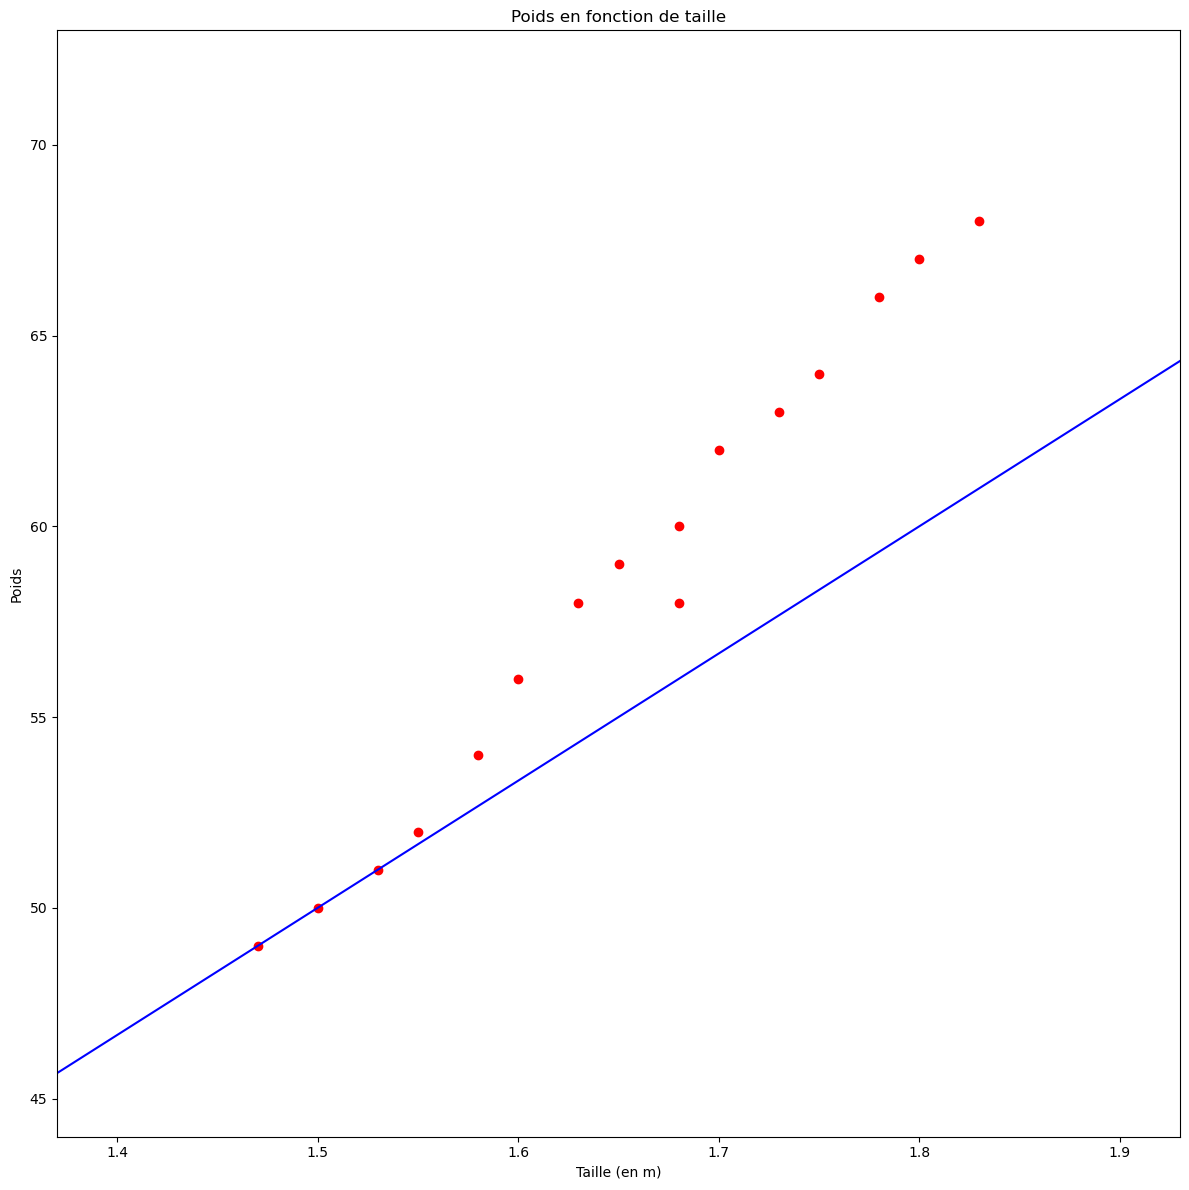

In [15]:
a,b = linsol.x[:2]

print(a,b)
plotDroite(x,y,a,b)

Tiens, ça ne semble pas marcher ?

Le problème vient des contraintes (implicites) sur $b$ : scicpy suppose par défaut que l'on souhaite que toutes les variables soient positives.
Cela peut se régler via l'option `bounds`.

>**Question 5 :** Régler ce problème via l'option `bounds`.


In [31]:
"""
TODO
"""

46.66666666666669 -20.400000000000034


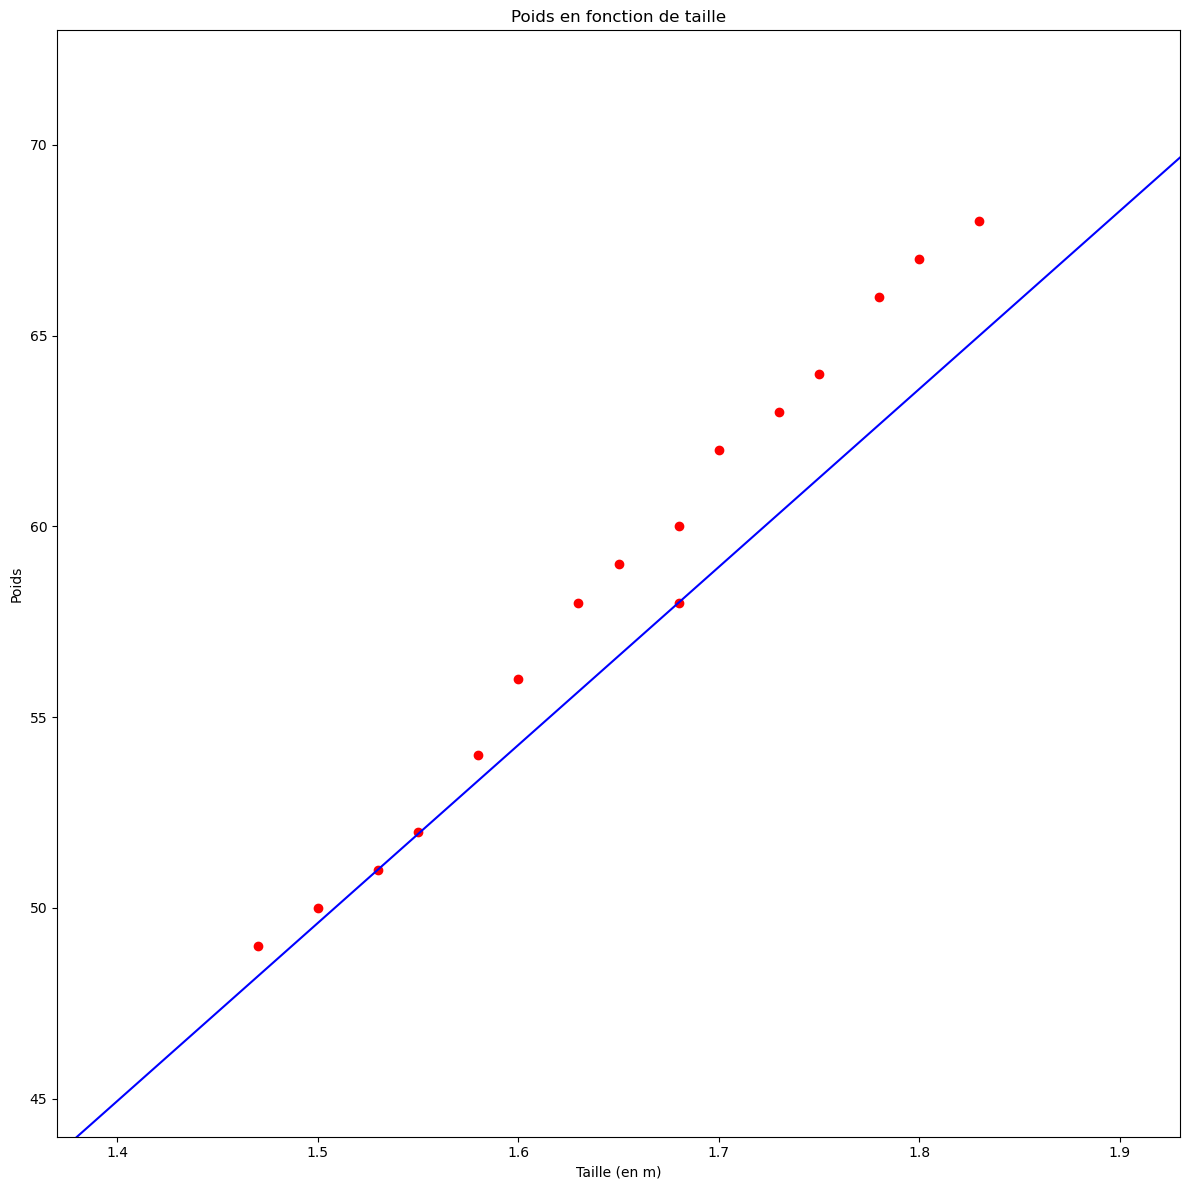

In [17]:
"""
TODO
"""
a,b = linsol.x[:2]

print(a,b)
plotDroite(x,y,a,b)

### Pour aller plus loin :

>**Question 6 :** Écrire une fonction qui trace simultanément les deux droites de regression obtenues par méthode *des moindres carrés* et d*e moindre valeur absolue*.
À l'aide de wigdets, observer les effets des __outliers__ (valeur anormalement différente de la distribution) sur les deux droites et les expliquer.